In [1]:
%load_ext autoreload
%load_ext memory_profiler 
%load_ext dotenv
%autoreload 2
%dotenv

In [2]:
from lightning import Trainer
from torchvision.transforms import v2 as T # type: ignore
from geovision.logging import get_logger
from geovision.config.basemodels import ExperimentConfig # noqa
from geovision.data.module import ImageDatasetDataModule
from geovision.io.local import get_ckpt_path, get_experiments_dir
from geovision.training.module import ClassificationModule
from geovision.training.loggers import (
    get_csv_logger, 
    # get_wandb_logger,
    get_ckpt_logger,
    # get_lr_logger,
    # get_classification_logger
)
from geovision.analysis.plot_experiment import plot_experiment

In [3]:
from typing import Any, Dict
from lightning import LightningModule
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.trainer import Trainer

class TrainStepPrinter(Callback):
    def __init__(self, config: ExperimentConfig):
        self.config = config
    
    def on_load_checkpoint(self, trainer: Trainer, pl_module: LightningModule, checkpoint: Dict[str, Any]) -> None:
        print("Callback: on_load_ckpt")
    
    def on_train_batch_end(self, trainer: Trainer, pl_module: LightningModule, outputs: Dict[str, Any], batch: Any, batch_idx: int) -> None:
        print("Callback: on_train_batch_end, trainer.global_step =", trainer.global_step)
    
    def on_validation_batch_end(self, trainer: Trainer, pl_module: LightningModule, outputs: Dict[str, Any], batch: Any, batch_idx: int, dataloader_idx: int = 0) -> None:
        print("Callback: on_val_batch_end, trainer.global_step =", trainer.global_step)

In [4]:
from torch import float32
from geovision.data.imagenette import Imagenette

logger = get_logger("experiment_logger")
transforms: dict[str, T.Transform | None] = {
    "image_transform": T.Compose([
        T.ToImage(), 
        T.Resize((224, 224), antialias=True), 
        T.ToDtype(float32, scale = True),
        T.Normalize(Imagenette.means, Imagenette.std_devs),
    ]),
    "target_transform": None,
    #"common_transform": None,
    "common_transform": T.RandomChoice([
        T.RandomHorizontalFlip(0.5),
        T.RandomVerticalFlip(0.5),
        T.RandomInvert(0.5),
        T.RandomAutocontrast(0.5)
    ]),
}
config = ExperimentConfig.from_yaml("config.yaml", transforms)
experiments_dir = get_experiments_dir(config)
datamodule = ImageDatasetDataModule(config)

loggers: list = list()
loggers.append(csv_logger := get_csv_logger(config))
# loggers.append(wandb_logger := get_wandb_logger(config))

callbacks: list = list()
callbacks.append(TrainStepPrinter(config))
callbacks.append(ckpt_logger := get_ckpt_logger(config))
#callbacks.append(metrics_logger := get_classification_logger(config))
# callbacks.append(lr_logger := get_lr_logger(config))
# callbacks.append(LearningRateFinder(num_training_steps=147, early_stop_threshold=None))

In [6]:
datamodule.setup('fit')
datamodule.train_dataset.num_test_samples

2679

In [9]:
trainer = Trainer(
    max_epochs = 5,
    check_val_every_n_epoch = 1,
    num_sanity_val_steps = 0,
    log_every_n_steps = 1,
    limit_train_batches = 5,
    limit_val_batches = 5,

    logger = loggers,
    callbacks = callbacks,
    enable_checkpointing = True,
    enable_model_summary = False
)

litmodule = ClassificationModule(ExperimentConfig.from_yaml("config.yaml", transforms))
trainer.fit(
    model = litmodule,
    datamodule = datamodule,
    ckpt_path = get_ckpt_path(config, epoch = 3)
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


"found ckpts: ['*epoch=3_step=20.ckpt']"

/home/sambhav/miniconda3/envs/dev/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/sambhav/experiments/imagenette_classification/testing_plotting/ckpts exists and is not empty.
Restoring states from the checkpoint path at /home/sambhav/experiments/imagenette_classification/testing_plotting/ckpts/epoch=3_step=20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restored all states from the checkpoint at /home/sambhav/experiments/imagenette_classification/testing_plotting/ckpts/epoch=3_step=20.ckpt


Callback: on_load_ckpt


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Callback: on_val_batch_end, trainer.global_step = 20
Callback: on_train_batch_end, trainer.global_step = 21
Callback: on_train_batch_end, trainer.global_step = 22
Callback: on_train_batch_end, trainer.global_step = 23
Callback: on_train_batch_end, trainer.global_step = 24
Callback: on_train_batch_end, trainer.global_step = 25


Validation: |          | 0/? [00:00<?, ?it/s]

Callback: on_val_batch_end, trainer.global_step = 25
Callback: on_val_batch_end, trainer.global_step = 25
Callback: on_val_batch_end, trainer.global_step = 25
Callback: on_val_batch_end, trainer.global_step = 25
Callback: on_val_batch_end, trainer.global_step = 25


`Trainer.fit` stopped: `max_epochs=5` reached.


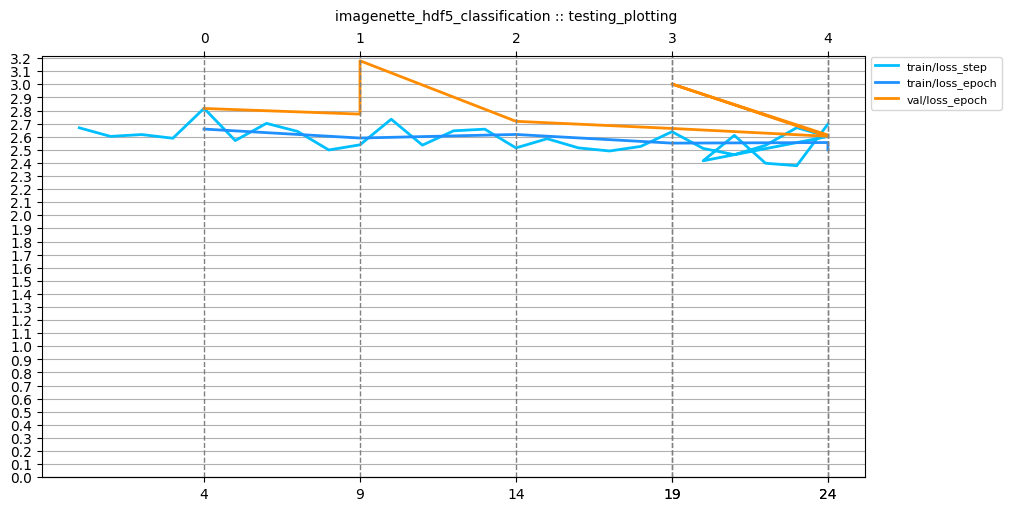

In [10]:
plot_experiment(config)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from geovision.analysis.viz import plot_confusion_matrix, plot_metrics_table
%matplotlib tk

fig, ax = plt.subplots(1, 1, figsize = (5, 5), layout = "constrained")
plot_confusion_matrix(ax, np.random.randint(0, 10, (5, 5)))